# Lab - Regularized Logistic Regression ##

**Objectives**: Implement Regularized Logistic Regression and get to see it works on data.

Regularization shrinks model parameters $\theta$ towards zero to prevent overfitting by reducing the variance of the model.

**Problem**: You will implement regularized logistic regression to predict whether microchips from a fabrication plant pass quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly. Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine if the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.


In [1]:
#Import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load Data¶
File *ex2data2.txt* contains the dataset for this problem.
The first two columns are the tests, the 3rd column indicates if the microchips should be accepted(1) or rejected(0).

Load data into the variable data (e.g. using function pd.read_csv from panda library) and then extract X (the features) and y (the labels).



In [2]:
data= pd.read_csv('ex2data2.txt',header=None)
 
#extract only the values from data frame 
data_n= data.values

X= data_n[:,0:2]

y=data_n[:, 2].reshape(-1,1)

##a few examples from the dataset 
data.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [3]:
data.describe()

,0,1,2
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


### Plot Data

Create a scatter plot of data similar to Fig.1 (using plt.scatter).

<img src="images/f3.png" style="width:350px;height:250px;">
<caption><center> **Fig. 1** : **file ex2data2.txt** </center></caption>

The axes are the two test scores, and the positive (y = 1, accepted) and negative (y = 0, rejected) examples are shown with different markers. 

Plotting the data clearly shows that the decision boundary that separates the different classes is a non-linear one. 
Therefore, a straightforward application of logistic regression will not perform well on this dataset since logistic regression will only be able to find a linear decision boundary.

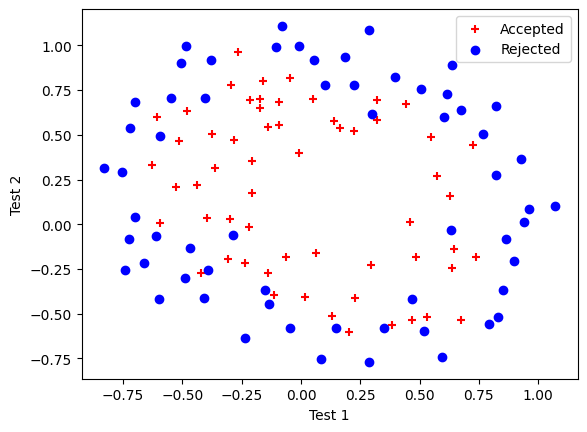

In [4]:
#Create Fig.1. The code is similar to the one in Part 1 of this lab. 
pos=(y==1)
neg=(y==0)
plt.scatter(X[pos[:,0],0],X[pos[:,0],1],c="r",marker="+")
plt.scatter(X[neg[:,0],0],X[neg[:,0],1],c="b",marker="o")

#add figure labels
plt.xlabel('Test 1')
plt.ylabel('Test 2')
plt.legend(['Accepted', 'Rejected'])

### Feature Mapping

One way to try to fit the data better is to create more features from the existing ones. 
In function *mapFeature*, we will map the features into polynomial terms of x1 and x2 up to the 6th power.

As a result of this mapping, the vector of two features (the scores on two QA tests) has been transformed into a 28-dimensional vector (Fig.2). A logistic regression classifier trained on this higher-dimensional feature vector will have a more complex decision boundary and will appear nonlinear when drawn in the original 2-dimensional plot. While the feature mapping allows us to build a better classifier, it is also more susceptible to overfitting. Now, you will implement regularized logistic regression to fit the data and see how regularization can deal with the overfitting problem.



<img src="images/f4.png" style="width:250px;height:200px;">
<caption><center> **Fig. 2** : **Polynomial features** </center></caption>


In [5]:
def mapFeature(x1,x2,degree):
    """
    take in numpy array of x1 and x2, return polynomial terms up to the given degree
    """
    out = np.ones((len(x1),1))
    for i in range(1,degree+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j).reshape(len(x1),1)
            out= np.hstack((out,terms))
    return out


In [6]:
degree=5  #better results than with degree=6
Xmap = mapFeature(X[:,0], X[:,1],degree)


### Computing Regularized Cost Function and Gradient

Complete the code in *costFunctionReg* to return the cost function and gradient for regularized logistic regression. 
The cost function now has an additional penalty term that is controlled by the regularization hyper-parameter λ (also known as ridge regression).

Note that you should not regularize the parameter  $\theta_0$ 

$J(\theta) = \frac{1}{m} \sum_{i=1}^{m} [ -y^{(i)}log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})log(1 - (h_{\theta}(x^{(i)}))] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)}$ for $j=0$

$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_{\theta}(x^{(i)}) - y^{(i)})x_j^{(i)} + \frac{\lambda}{m}\theta_j$ for $j\geq 1$

In [7]:
# Add sigmoid function. The same function as in Part 1

def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    gz=1/(1+np.exp(-z))
    
    return gz

In [8]:
 def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    #number of training examples 
    m=X.shape[0]
        
    #vector of the model predictions for all training examples      
    h = 1/(1+np.exp(-np.dot(X,theta)))
    
    error = (-y * np.log(h)) - ((1-y)*np.log(1-h))
    
    #cost function without regularization term
    cost = sum(error)/m
    
    #add regularization term to the cost function L2 norm
    regCost= cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    #gradient of theta_0
    grad_0= (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    #vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all=np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

Initialize VECTOR initial_theta to 0 and call *costFunctionReg* function.

In [9]:
# Initialize fitting parameters
initial_theta = np.zeros((Xmap.shape[1],1))

# Set regularization parameter lambda to 0
Lambda = 0

#Call CostFunctionReg and get the cost and gradients for initial_theta
cost, grad= costFunctionReg(Xmap,y,initial_theta, Lambda)

print("Cost for initial theta is",round(cost,3) )  #ANSWER: Cost for initial theta is 0.693


Cost for initial theta is 0.693


### Gradient Descent

Complete gradientDescent function, the same as in Part 1. 

In [10]:
def gradientDescent(X,y,theta,alpha,num_iters,Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        #call CostFunctionReg 
        cost, grad = costFunctionReg(X,y,theta, Lambda)
        
        #update theta
        theta = theta-alpha*grad
        
        J_history.append(cost)
    
    return theta , J_history


### TESTS 

Make tests with different values of λ, keeping the learning rate alpha=0.5. Get similar plots as below. 

**λ = 0, iterat=10000, Train Accuracy:84.75 %**

<img src="images/l0_a05_it10000_plot2.png" style="width:250px;height:200px;">
<caption><center> **Fig. 3** : **Cost function evolution (λ = 0, 10000 iterations !!!)** </center></caption>


<img src="images/l0_a05_it10000_plot1.png" style="width:250px;height:200px;">
<caption><center> **Fig. 4** : **λ = 0,Train Accuracy: 84.75 %** </center></caption>

**λ = 1, iterat=1000, Train Accuracy: 83.90 %**

<img src="images/l1_a05_it1000_plot2.png" style="width:250px;height:200px;">
<caption><center> **Fig. 5** : **Cost function evolution (λ = 1, 1000 iterations !!!)** </center></caption>


<img src="images/l1_a05_it1000_plot1.png" style="width:250px;height:200px;">
<caption><center> **Fig. 6** : **λ = 1,Train Accuracy: 83.90 %** </center></caption>


**λ = 10, iterat=200, Train Accuracy: 71.2 %**

<img src="images/L10_a05_it200_plot2.png" style="width:250px;height:200px;">
<caption><center> **Fig. 7** : **Cost function evolution (λ = 10, 200 iterations !!!)** </center></caption>
<img src="images/L10_a05_it200_plot1.png" style="width:250px;height:200px;">
<caption><center> **Fig. 8** : **λ = 10,Train Accuracy: 71.20 %** </center></caption>


In [11]:
Lambda =[0,1,10]
alpha=0.5
iterat=[10000,1000,200]
l=[0,1,2]
theta_list=[]
J_history_all=[]

for i in l:
    initial_theta = np.zeros((Xmap.shape[1],1))
    theta , J_history = gradientDescent(Xmap,y,initial_theta,alpha,iterat[i],Lambda[i])
    theta_list.append(theta)
    J_history_all.append(J_history)

### Plot the Cost function

to get curves similar to Fig.3, Fig.5. 

Text(0.5, 1.0, 'Cost function using Gradient Descent')

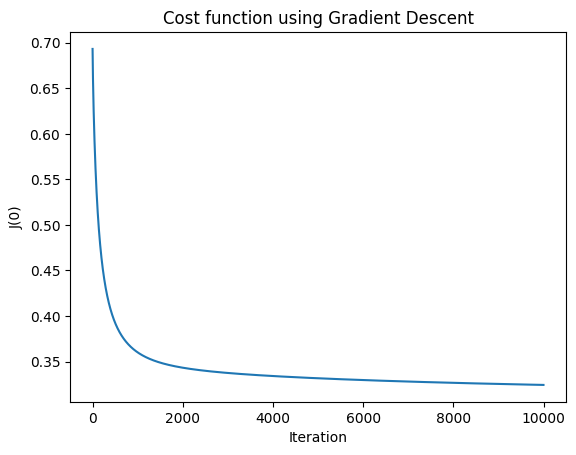

In [12]:
plt.plot(J_history_all[0])
plt.xlabel('Iteration')
plt.ylabel('J(0)')
plt.title('Cost function using Gradient Descent')

Text(0.5, 1.0, 'Cost function using Gradient Descent')

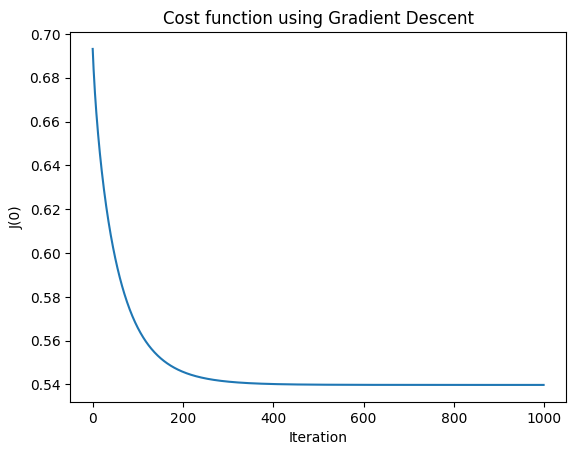

In [13]:
plt.plot(J_history_all[1])
plt.xlabel('Iteration')
plt.ylabel('J(0)')
plt.title('Cost function using Gradient Descent')

Text(0.5, 1.0, 'Cost function using Gradient Descent')

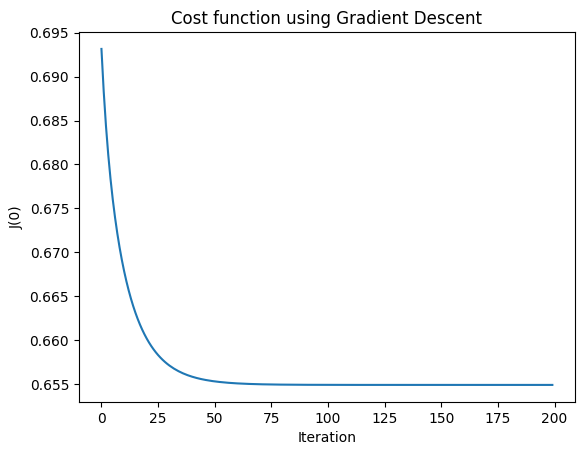

In [14]:
plt.plot(J_history_all[2])
plt.xlabel('Iteration')
plt.ylabel('J(0)')
plt.title('Cost function using Gradient Descent')

# Plot the data and the decision boundary

In [15]:
def mapFeaturePlot(x1,x2,degree):
    """
    take in numpy array of x1 and x2, return all polynomial terms up to the given degree
    """
    out = np.ones(1)
    for i in range(1,degree+1):
        for j in range(i+1):
            terms= (x1**(i-j) * x2**j)
            out= np.hstack((out,terms))
    return out

Text(0.5, 1.0, 'Lambda =0, alpha=0.5, iterat=10000')

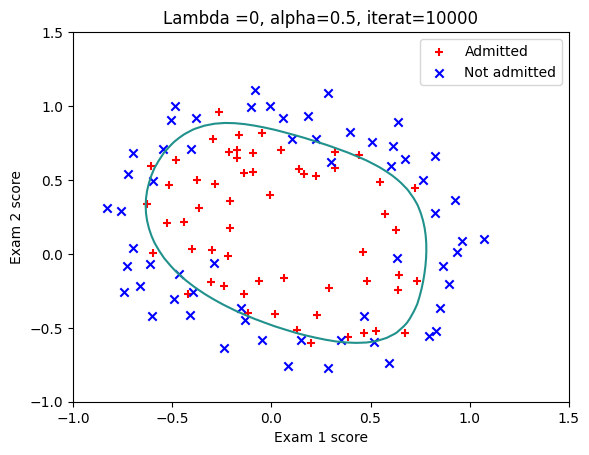

In [16]:
plt.scatter(Xmap[pos[:,0],1],Xmap[pos[:,0],2],c="r",marker="+",label="Admitted")
plt.scatter(Xmap[neg[:,0],1],Xmap[neg[:,0],2],c="b",marker="x",label="Not admitted")

# Plotting decision boundary

u_vals = np.linspace(-1,1.5,50)
v_vals= np.linspace(-1,1.5,50)
z=np.zeros((len(u_vals),len(v_vals)))
for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        z[i,j] =mapFeaturePlot(u_vals[i],v_vals[j],degree) @ theta_list[0]

plt.contour(u_vals,v_vals,z.T,0)
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.title('Lambda =0, alpha=0.5, iterat=10000')

Text(0.5, 1.0, 'Lambda =1, alpha=0.5, iterat=1000')

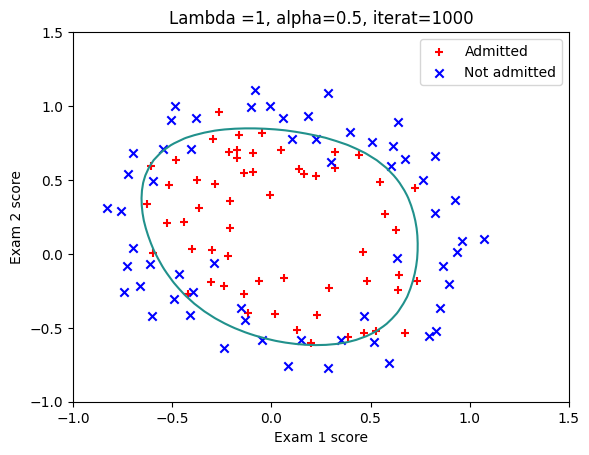

In [17]:
plt.scatter(Xmap[pos[:,0],1],Xmap[pos[:,0],2],c="r",marker="+",label="Admitted")
plt.scatter(Xmap[neg[:,0],1],Xmap[neg[:,0],2],c="b",marker="x",label="Not admitted")

# Plotting decision boundary

u_vals = np.linspace(-1,1.5,50)
v_vals= np.linspace(-1,1.5,50)
z=np.zeros((len(u_vals),len(v_vals)))
for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        z[i,j] =mapFeaturePlot(u_vals[i],v_vals[j],degree) @ theta_list[1]

plt.contour(u_vals,v_vals,z.T,0)
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.title('Lambda =1, alpha=0.5, iterat=1000')

Text(0.5, 1.0, 'Lambda =10, alpha=0.5, iterat=200')

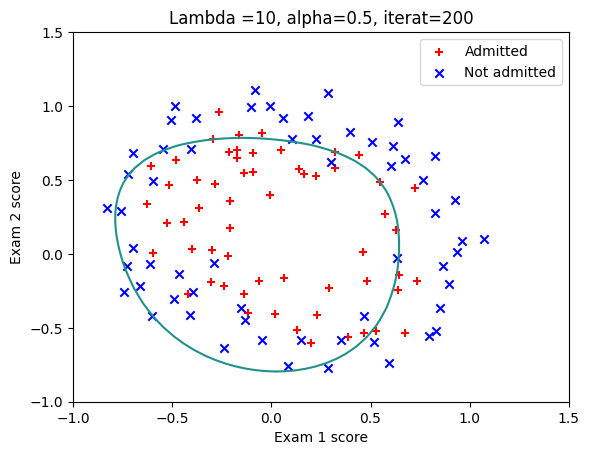

In [18]:
plt.scatter(Xmap[pos[:,0],1],Xmap[pos[:,0],2],c="r",marker="+",label="Admitted")
plt.scatter(Xmap[neg[:,0],1],Xmap[neg[:,0],2],c="b",marker="x",label="Not admitted")

# Plotting decision boundary

u_vals = np.linspace(-1,1.5,50)
v_vals= np.linspace(-1,1.5,50)
z=np.zeros((len(u_vals),len(v_vals)))
for i in range(len(u_vals)):
    for j in range(len(v_vals)):
        z[i,j] =mapFeaturePlot(u_vals[i],v_vals[j],degree) @ theta_list[2]

plt.contour(u_vals,v_vals,z.T,0)
plt.xlabel("Exam 1 score")
plt.ylabel("Exam 2 score")
plt.legend(loc=0)
plt.title('Lambda =10, alpha=0.5, iterat=200')

### Model accuracy on train data

The same as in part 1. 

In [19]:
def classifierPredict(theta,X):
    """
    take in numpy array of theta and X and predict the class 
      """
     
    predictions =  1/(1+np.exp(-np.dot(X,theta)))
    
    return predictions>=0.5

In [21]:
# The same as in Part 1
p=classifierPredict(theta_list[1],Xmap)
print("Train Accuracy:",(sum(p==y)/len(y)*100)[0],"%") 

Train Accuracy: 83.89830508474576 %


## sklearn library to solve the same problem 

Call LogisticRegression as in Part 1, but now add penalty="l2" to solve the same problem. 

In [22]:
from sklearn.linear_model import LogisticRegression

y=data_n[:,2]  # has to be  1d array

logitN = LogisticRegression(penalty='l2')
logitN.fit(Xmap,y)
print('Accuracy of log reg classifier')
print(logitN.score(Xmap, y))

Accuracy of log reg classifier
0.8389830508474576
